# Understanding the Attention layer with a toy sequential task

François Fleuret came up with a toy sequential processing task that I found really helpful for gaining better intuition behind attention layers. In this notebook I am just going to take his code and work through it. I find going through examples in notebooks to be really helpful, especially when hacking existing code. 

The task is summarized by this slide from François' deep learning course EE-559: 

<div>
<img src="https://i.imgur.com/ez02xV9.png" width="700"/>
</div>

Basically, the input consists of a pairs of triangle and rectangle shapes at different heights. The output needs to the same shapes but each pair needs to have the same average height. The slide below highlights how the input triangle pairs will have the same height in the target output (computed as the average height of their inputs):


<div>
<img src="https://i.imgur.com/zDHnv7B.png" width="700"/>
</div>


You can find François' original code here: https://fleuret.org/git-extract/pytorch/attentiontoy1d.py

The code I use here is simply a tweaked/hacked version of François' hard work 🙏

In [1]:
import torch, math, sys

from torch import nn
from torch.nn import functional as F

import matplotlib.pyplot as plt

# Data generation
François has done the hard work for us by providing functions that generate the types of sequences we want. The details of these functions are not important for understanding how attention layers work, so we can just instantiate them as a data generating object `data_gen`. 

In [2]:
import utils

data_gen = utils.DataUtil(seq_height_min = 1.0, 
                          seq_height_max = 25.0,
                          seq_width_min = 5.0, 
                          seq_width_max = 11.0,
                          seq_length = 100,
                          group_by_locations = False
                         )

In [3]:
train_input, train_targets, train_tr, train_bx = data_gen.generate_sequences(25000)
test_input, test_targets, test_tr, test_bx = data_gen.generate_sequences(1000)

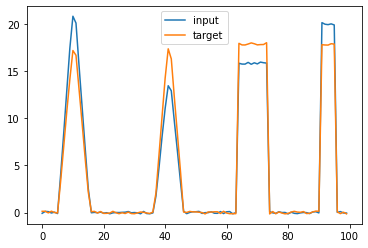

In [4]:
plt.plot(train_input[1,0,:], label = "input")
plt.plot(train_targets[1,0,:], label = "target")
plt.legend();

# Attention Layer

This is where all the action is!

The problem is we want to have a layer that *transforms* sequential data into something more useful for a downstream task. 

Here is our starting point: we have a sequence of feature vectors $\{x_1, x_2, \ldots, x_n\}$ where each feature vector $x_i$ has the same dimension $d$. We could put together all these feature vectors together as a one big matrix $\mathbf{X} = [ x_1, x_2, \ldots, x_n]^{T}$ with $n$ rows and $d$ columns (so a stack of $d$ dimensional row vectors). I usually prefer the feature vectors to be column vectors, but I think most tutorials and articles like to represent the sequence of feature vectors as stacks like this so I will go with it.


## Sequence of length one case

But before we deal with the full sequence, lets start with a simple dummy case $n= 1$ when the sequence just has length 1. In that case $\mathbf{X} = x_{1}^{T}$ would just be a single row vector with $d$ elements.


Unlike a fully connected or convolutional layer, an Attention layer requires *three* intermediate transformations that are referred to as query, key, and value. That might sound complicated, but its just three different matrix multiplications:
\begin{align}
q_1 = x_1 W_q  \\
k_1 = x_1 W_k  \\
v_1 = x_1 W_v 
\end{align}

In Linear Algebra jargon, our original feature vector $x_1$ gets projected to *three* different vector spaces spanned by the $W_q$, $W_k$, and $W_v$ matrices. In neural net terminology, we could see these as three different linear fully connected layers. 

Normally with an MLP, we just have a single fully connected layer and that might be just the feature "value" we need and so the transformation $v_1 = x_1 W_v$ would give us the hidden feature representation that we need. 

**What the Attention layer does is tell us whether a feature value is worth keeping or not.** How we determine if we keep a feature value or not is based on a soft "look up" operation with the query and key vectors. In our simple sequence that has just one element this soft lookup is computed as
\begin{align}
a = \sigma(q_1 k_1^{T})
\end{align}

Recall that $q_1$ and $k_1$ are both row vectors, so $a$ is just a scalar and since its being passed through a sigmoid it is between 0 and 1. Having computed the attention "vector" (which in this case is such a scalar because our sequence has length 1), the output of the attention layer can now be computed as:

\begin{align}
z_1 = a v_1 
\end{align}

Instead of breaking this into multiple steps, we could have also equivalently written this as:



\begin{align}
z_1 = \sigma(q_1 k_1^{T})v_1 
\end{align}

In the usual MLP, the $a = 1$ and our hidden representation would just be $v_1$. But when we have $a =\sigma(q_1 k_1^{T})$ we have $0 < a < 1$ and effectively have a gating factor control just by how much we want to keep the feature value $v_1$.

## Sequence of length $n$ case

When a sequence has just length one, this gating is not so interesting. Things get more interesting when we have sequences that are longer. If we have two sequences $x_1$ and $x_2$ then we can calculate

\begin{align}
q_1 = x_1 W_q, \;  q_2 = x_2 W_q\\
k_1 = x_1 W_k, \;  k_2 = x_2 W_k \\
v_1 = x_1 W_v, \;  v_2 = x_2 W_v 
\end{align}

Of course, since we are applying the *same* $W_q$, $W_k$, and $W_v$ matrices to each sequence element, we can compute the query feature vectors as

\begin{align}
\begin{bmatrix} q_1\\ q_2 \end{bmatrix} = \begin{bmatrix} x_1\\ x_2 \end{bmatrix} W_q,
\end{align}

the key feature vectors as

\begin{align}
\begin{bmatrix} k_1\\ k_2 \end{bmatrix} = \begin{bmatrix} x_1\\ x_2 \end{bmatrix} W_k,
\end{align}

and the value feature vectors as 

\begin{align}
\begin{bmatrix} v_1\\ v_2 \end{bmatrix} = \begin{bmatrix} x_1\\ x_2 \end{bmatrix} W_v.
\end{align}

The query, key, and value transformation matrices $W_q$, $W_k$, and $W_v$ don't care what the length of the sequence is. Another way of thinking about this is we are applying the three separate fully connected layers to each feature vector in the sequence. Pictorially, these operations can be visualized with this diagram created by Jay Alammar (taken from his [excellent tutorial](http://jalammar.github.io/illustrated-transformer/)):


<div>
<img src="http://jalammar.github.io/images/t/self-attention-matrix-calculation.png" width="400"/>
</div>

Note in Jay's illustration, the left-hand-side and right-hand-side are swapped with what I've shown. 



Finally, now that we have the query, key, and value feature vectors, we can calculate which parts of the value feature vector to attend to. But now that we have a sequence greater than length 1, we don't have a single attention gate but rather a *matrix* $A$ of attentions that considers all possibly pairwise combinations including to itself:

\begin{align}
A = \sigma\left(\begin{bmatrix} q_1\\ q_2 \end{bmatrix} \begin{bmatrix} k_1^{T} & k_2^{T} \end{bmatrix} \right)
\end{align}

where $\sigma(\cdot)$ is the softmax function. Having calculated the attention matrix $A$ we can now compute the the hidden sequence representation as:

\begin{align}
\begin{bmatrix} z_1\\ z_2 \end{bmatrix}=  A \begin{bmatrix} v_1\\ v_2 \end{bmatrix}.
\end{align}


We can of course write this more compactly as

\begin{align}
\begin{bmatrix} z_1\\ z_2 \end{bmatrix}=  \sigma\left(\begin{bmatrix} q_1\\ q_2 \end{bmatrix} \begin{bmatrix} k_1^{T} & k_2^{T} \end{bmatrix} \right) \begin{bmatrix} v_1\\ v_2 \end{bmatrix}.
\end{align}
 
and we can again view this pictorially as



<div>
<img src="http://jalammar.github.io/images/t/self-attention-matrix-calculation-2.png" width="500"/>
</div>

where the left-hand-side and right-hand-side are swapped.



**And that's our attention layer!** To summarize, lets breakdown what we did in steps:

1. The attention layer first linearly transforms each feature vector in the input sequence into three sequences of query, key, and value feature vectors. 

2. The sequence of query and key feature are then multiplied by an "outer-product" operation and scaled by the softmax function to create an attention matrix $A$. The attention matrix $A$ is a square matrix its number of rows and columns equals the length of the input sequence. 

3. Finally, the sequence of value feature vectors is scaled by the attention matrix $A$ to create the output sequence feature vector.


In transformer architecture, this would be called a "single attention head" and in general transformer architecture have multiple heads. Each head has the same operations here but because the query, key, and value transformations are different for each head (ie, initialized to different values at the start of training), they represent different features and different notions of attention. 


For our toy example here however we don't need multiple heads and one head will do just fine. 

## AttentionLayer class definition

In [5]:
class AttentionLayer(nn.Module):
    def __init__(self, in_channels, out_channels, key_channels):
        super(AttentionLayer, self).__init__()
        self.conv_Q = nn.Conv1d(in_channels, key_channels, kernel_size = 1, bias = False)
        self.conv_K = nn.Conv1d(in_channels, key_channels, kernel_size = 1, bias = False)
        self.conv_V = nn.Conv1d(in_channels, out_channels, kernel_size = 1, bias = False)

    def forward(self, x):
        Q = self.conv_Q(x)
        K = self.conv_K(x)
        V = self.conv_V(x)
        A = Q.permute(0, 2, 1).matmul(K).softmax(2)
        x = A.matmul(V.permute(0, 2, 1)).permute(0, 2, 1)
        return x

    def __repr__(self):
        return self._get_name() + \
            '(in_channels={}, out_channels={}, key_channels={})'.format(
                self.conv_Q.in_channels,
                self.conv_V.out_channels,
                self.conv_K.out_channels
            )

    def attention(self, x):
        Q = self.conv_Q(x)
        K = self.conv_K(x)
        return Q.permute(0, 2, 1).matmul(K).softmax(2)

In [6]:
sample_seq = torch.randn(1,3,6, names = ("batch", 'features', 'seq'))
#sample_seq = torch.randn(1,3,6)

<ipython-input-6-6ec532055b02>:1: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1595629449223/work/c10/core/TensorImpl.h:840.)
  sample_seq = torch.randn(1,3,6, names = ("batch", 'features', 'seq'))


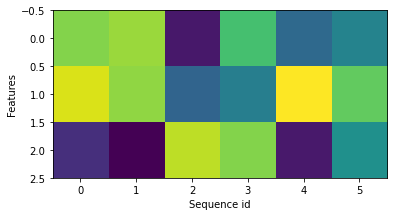

In [7]:
#plt.figure(figsize = (24,12))


plt.imshow(sample_seq[0]);
plt.xlabel("Sequence id");
plt.ylabel("Features");

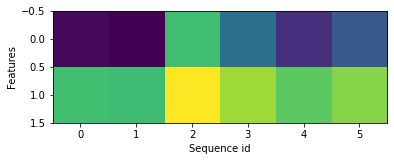

In [8]:
attention_layer = AttentionLayer(in_channels=3, out_channels=2, key_channels=3)
z = attention_layer((sample_seq.rename(None)))
plt.imshow(z[0].detach().numpy());
plt.xlabel("Sequence id");
plt.ylabel("Features");

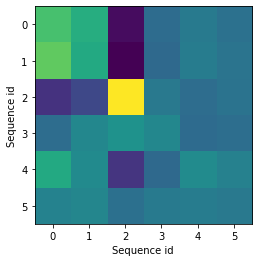

In [9]:
plt.imshow(attention_layer.attention((sample_seq.rename(None)))[0].detach().numpy())
plt.xlabel("Sequence id")
plt.ylabel("Sequence id");

# Network architecture

In [10]:
in_channels = 1 #+ positional_input.size(1)
ks = 5
nc = 64

model = nn.Sequential(
    nn.Conv1d(in_channels, nc, kernel_size = ks, padding = ks//2),
    nn.ReLU(),
    nn.Conv1d(nc, nc, kernel_size = ks, padding = ks//2),
    nn.ReLU(),
    AttentionLayer(nc, nc, nc),
    nn.ReLU(),
    nn.Conv1d(nc, nc, kernel_size = ks, padding = ks//2),
    nn.ReLU(),
    nn.Conv1d(nc,  1, kernel_size = ks, padding = ks//2)
)

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
mse_loss = nn.MSELoss()

## Transfer data to device

In [12]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device('cpu')

In [13]:
model.to(device)
mse_loss.to(device)
train_input, train_targets = train_input.to(device), train_targets.to(device)
test_input, test_targets = test_input.to(device), test_targets.to(device)

In [14]:
mu, std = train_input.mean(), train_input.std()
mu, std

(tensor(3.3201), tensor(6.2421))

# Run training loop

In [15]:
nb_epochs = 250
batch_size = 100

In [16]:
%%time
for e in range(nb_epochs):

    acc_loss = 0.0

    for tr_in, tr_target in zip(train_input.split(batch_size),
                             train_targets.split(batch_size)):
        

        #input = torch.cat((input, positional_input.expand(input.size(0), -1, -1)), 1)

        output = model((tr_in - mu) / std)
        loss = mse_loss(output, tr_target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc_loss += loss.item()

    print(f'{e+1} {acc_loss}')
    
    break


1 1482.7921084165573
CPU times: user 1min 39s, sys: 5.31 s, total: 1min 44s
Wall time: 26.8 s
